In [1]:
# ==============================
# 라이브러리
# ==============================
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

# ==============================
# 시드 고정 (재현성 확보)
# ==============================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda:8" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ==============================
# 특수 토큰 정의
# ==============================
PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"

# ==============================
# 숫자 덧셈 Dataset 정의
# ==============================
class AddDataset(Dataset):
    def __init__(self, n_samples=50000, n_digits=5, src_stoi=None, tgt_stoi=None):
        self.samples = []
        for _ in range(n_samples):
            a = random.randint(10**(n_digits-1), 10**n_digits - 1)
            b = random.randint(10**(n_digits-1), 10**n_digits - 1)
            src = f"{a}+{b}"              # 입력: "12345+67890"
            tgt = str(a+b)                # 출력: "80235"
            self.samples.append((src, tgt))

        # 공통 vocab 생성 (숫자 + 연산자)
        tokens = list("0123456789+")
        special = [PAD, SOS, EOS]
        vocab = special + tokens

        # 입력 사전
        if src_stoi is None:
            self.src_stoi = {ch: i for i, ch in enumerate(vocab)}
        else:
            self.src_stoi = src_stoi
        self.src_itos = {i: ch for ch, i in self.src_stoi.items()}

        # 출력 사전 (입력과 동일)
        if tgt_stoi is None:
            self.tgt_stoi = self.src_stoi
        else:
            self.tgt_stoi = tgt_stoi
        self.tgt_itos = {i: ch for ch, i in self.tgt_stoi.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        src, tgt = self.samples[idx]
        src_ids = [self.src_stoi[SOS]] + [self.src_stoi[c] for c in src] + [self.src_stoi[EOS]]
        tgt_ids = [self.tgt_stoi[SOS]] + [self.tgt_stoi[c] for c in tgt] + [self.tgt_stoi[EOS]]
        return torch.tensor(src_ids), torch.tensor(tgt_ids), src, tgt

# ==============================
# collate_fn: 배치 패딩
# ==============================
def collate_fn(batch):
    src_batch, tgt_batch, src_strs, tgt_strs = zip(*batch)
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=train_dataset.src_stoi[PAD])
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=train_dataset.tgt_stoi[PAD])
    return src_batch, tgt_batch, src_strs, tgt_strs

# ==============================
# 데이터셋 생성
# ==============================
train_samples, test_samples = train_test_split(range(50000), test_size=0.2, random_state=seed)

train_dataset = AddDataset(n_samples=len(train_samples), n_digits=5)
test_dataset = AddDataset(n_samples=len(test_samples), n_digits=5,
                          src_stoi=train_dataset.src_stoi,
                          tgt_stoi=train_dataset.tgt_stoi)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# ==============================
# 데이터 예시 출력
# ==============================
for src_batch, tgt_batch, src_strs, tgt_strs in train_loader:
    print("입력 배치 shape:", src_batch.shape)
    print("출력 배치 shape:", tgt_batch.shape)
    print("첫 번째 샘플 원문:", src_strs[0], "→", tgt_strs[0])
    print("첫 번째 입력 인덱스:", src_batch[0][:20].tolist())
    print("첫 번째 출력 인덱스:", tgt_batch[0][:20].tolist())
    break


Device: cuda:8
입력 배치 shape: torch.Size([64, 13])
출력 배치 shape: torch.Size([64, 8])
첫 번째 샘플 원문: 88410+94490 → 182900
첫 번째 입력 인덱스: [1, 11, 11, 7, 4, 3, 13, 12, 7, 7, 12, 3, 2]
첫 번째 출력 인덱스: [1, 4, 11, 5, 12, 3, 3, 2]


In [2]:
import torch.nn as nn

class TransformerAdd(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, nhead=4, ffn_dim=256, nlayers=2, pad_idx=0, max_len=50):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.pos_emb = nn.Embedding(max_len, emb_dim)

        self.transformer = nn.Transformer(
            d_model=emb_dim,
            nhead=nhead,
            num_encoder_layers=nlayers,
            num_decoder_layers=nlayers,
            dim_feedforward=ffn_dim,
            batch_first=True
        )
        self.fc_out = nn.Linear(emb_dim, vocab_size)
        self.pad_idx = pad_idx

    def forward(self, src, tgt):
        B, S = src.size()
        _, T = tgt.size()

        pos_src = torch.arange(S, device=src.device).unsqueeze(0).expand(B, S)
        pos_tgt = torch.arange(T, device=tgt.device).unsqueeze(0).expand(B, T)

        src_emb = self.emb(src) + self.pos_emb(pos_src)
        tgt_emb = self.emb(tgt) + self.pos_emb(pos_tgt)

        # 마스크 생성 (디코더용 causal mask)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(T).to(src.device)

        out = self.transformer(src_emb, tgt_emb, tgt_mask=tgt_mask)
        return self.fc_out(out)  # [B,T,V]


Epoch 001 | Train Loss 1.5657 | Train Acc 0.4015
Epoch 002 | Train Loss 0.5393 | Train Acc 0.7996
Epoch 003 | Train Loss 0.0738 | Train Acc 0.9767
Epoch 004 | Train Loss 0.0422 | Train Acc 0.9872
Epoch 005 | Train Loss 0.0347 | Train Acc 0.9901
Epoch 006 | Train Loss 0.0175 | Train Acc 0.9949
Epoch 007 | Train Loss 0.0153 | Train Acc 0.9956
Epoch 008 | Train Loss 0.0231 | Train Acc 0.9937
Epoch 009 | Train Loss 0.0210 | Train Acc 0.9943
Epoch 010 | Train Loss 0.0109 | Train Acc 0.9969


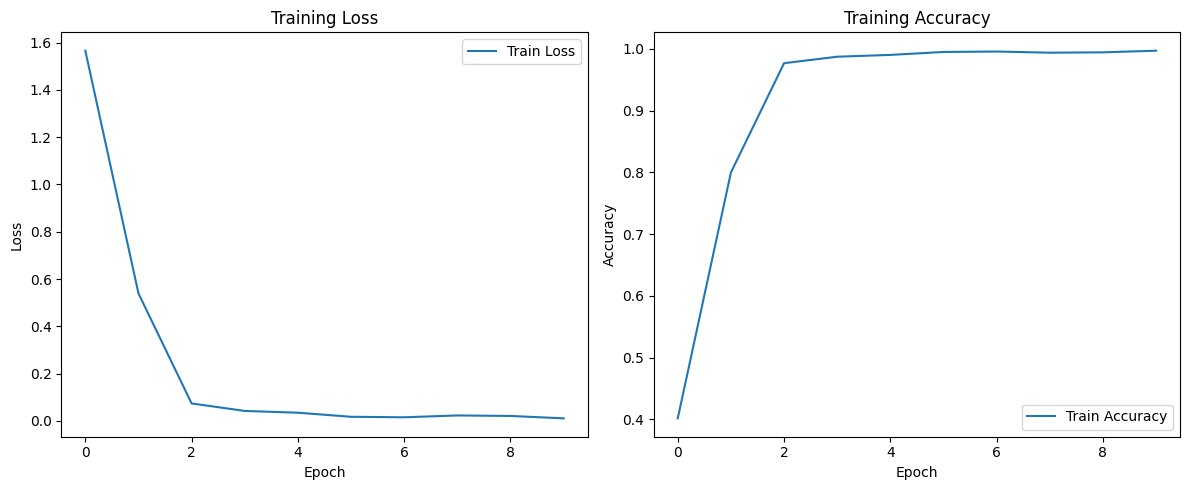

In [3]:
import torch.optim as optim
import matplotlib.pyplot as plt

PAD_IDX = train_dataset.src_stoi[PAD]
vocab_size = len(train_dataset.src_stoi)

model = TransformerAdd(vocab_size=vocab_size, pad_idx=PAD_IDX).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

N_EPOCHS = 10

# 기록용 리스트
train_losses = []
train_accs = []

for epoch in range(1, N_EPOCHS+1):
    model.train()
    total_loss = 0
    total_acc = 0

    for src, tgt, _, _ in train_loader:
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        # 입력은 [:-1], 타깃은 [1:] (teacher forcing)
        output = model(src, tgt[:, :-1])             # [B, T-1, V]
        loss = criterion(output.reshape(-1, vocab_size), tgt[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy 계산
        with torch.no_grad():
            pred_tokens = output.argmax(dim=-1)     # [B, T-1]
            true_tokens = tgt[:, 1:]                # [B, T-1]
            mask = (true_tokens != PAD_IDX)         # PAD 제외
            correct = (pred_tokens == true_tokens) & mask
            acc = correct.sum().float() / mask.sum().float()
            total_acc += acc.item()

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)

    train_losses.append(avg_loss)
    train_accs.append(avg_acc)

    print(f"Epoch {epoch:03d} | Train Loss {avg_loss:.4f} | Train Acc {avg_acc:.4f}")

# ==============================
# 학습 곡선 그래프 출력
# ==============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
@torch.no_grad()
def greedy_decode(model, src_str, stoi, itos, device, max_len=10):
    model.eval()
    # 입력 인덱스 변환
    src_ids = [stoi[SOS]] + [stoi[c] for c in src_str] + [stoi[EOS]]
    src = torch.tensor(src_ids, device=device).unsqueeze(0)

    # 초기 <SOS>
    tgt = torch.tensor([[stoi[SOS]]], device=device)

    for _ in range(max_len):
        out = model(src, tgt)  # [1,T,V]
        next_token = out[:,-1,:].argmax(-1, keepdim=True)
        tgt = torch.cat([tgt, next_token], dim=1)

        if next_token.item() == stoi[EOS]:
            break

    return "".join([itos[i.item()] for i in tgt[0][1:] if itos[i.item()] not in [PAD, SOS, EOS]])


In [5]:
import random

@torch.no_grad()
def show_examples(model, dataset, stoi, itos, device="cpu", n=10):
    model.eval()
    indices = random.sample(range(len(dataset)), n)
    print("\n=== Transformer 덧셈 예시 출력 ===")
    for idx in indices:
        src_ids, tgt_ids, src_str, tgt_str = dataset[idx]
        pred_str = greedy_decode(model, src_str, stoi, itos, device=device, max_len=8)

        # 정답과 예측을 숫자로 변환해 오차 계산
        try:
            true_val = int(tgt_str)
            pred_val = int(pred_str)
            error = abs(true_val - pred_val)
        except ValueError:
            error = "N/A"  # 예측이 숫자로 안 나올 경우

        print(f"입력: {src_str:<15} | 정답: {tgt_str:<10} | 예측: {pred_str:<10} | 오차: {error}")


In [6]:
# ==============================
# 학습 완료 후 예시 출력
# ==============================
show_examples(
    model, 
    test_dataset, 
    train_dataset.src_stoi,  # stoi
    train_dataset.src_itos,  # itos
    device=device, 
    n=10
)



=== Transformer 덧셈 예시 출력 ===
입력: 47200+81294     | 정답: 128494     | 예측: 128494     | 오차: 0
입력: 22851+71862     | 정답: 94713      | 예측: 94713      | 오차: 0
입력: 53225+71449     | 정답: 124674     | 예측: 124674     | 오차: 0
입력: 82946+12871     | 정답: 95817      | 예측: 95817      | 오차: 0
입력: 85047+57833     | 정답: 142880     | 예측: 142880     | 오차: 0
입력: 78038+49310     | 정답: 127348     | 예측: 127348     | 오차: 0
입력: 42516+10838     | 정답: 53354      | 예측: 53354      | 오차: 0
입력: 81290+95242     | 정답: 176532     | 예측: 176532     | 오차: 0
입력: 96573+73747     | 정답: 170320     | 예측: 170320     | 오차: 0
입력: 48078+33678     | 정답: 81756      | 예측: 81756      | 오차: 0
